In [1]:
# stdlib
from typing import Any, List

# third party
import numpy as np
import pandas as pd
#from ctgan import CTGAN

# synthcity absolute
from synthcity.plugins.core.dataloader import DataLoader, GenericDataLoader
from synthcity.plugins.core.distribution import Distribution
from synthcity.plugins.core.plugin import Plugin
from synthcity.plugins.core.schema import Schema
from synthcity.plugins.core.distribution import (
    Distribution,
    IntegerDistribution,
)
from tabpfn import TabPFNClassifier
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
#from ForestDiffusion import ForestDiffusionModel
from synthcity.plugins import Plugins
from smote import MySMOTE
from imblearn.over_sampling import SMOTE

In [104]:
torch.__version__

'1.13.1+cu117'

In [117]:
class tabpfn_points_plugin(Plugin):
    """TabPFN integration in synthcity."""

    def __init__(
        self,
        n_random_test_samples: int = 3_000,
        device: str = "cuda:0",
        n_batches: int = 200,
        lr: float = 0.1,
        n_permutations: int = 3,
        n_ensembles: int = 3,
        store_intermediate_data: bool = False,
        n_test_from_false_train: int = 0,
        n_random_features_to_add: int = 1,
        random_test_points_scale: float = 2,
        init_scale_factor: float = 5,
        **kwargs: Any
    ) -> None:
        super().__init__(**kwargs)
        self.n_random_test_samples = n_random_test_samples
        self.device = device
        self.n_batches = n_batches
        self.lr = lr
        self.n_permutations = n_permutations
        self.n_ensembles = n_ensembles
        self.preprocessor = StandardScaler()
        self.store_intermediate_data = store_intermediate_data
        self.n_test_from_false_train = n_test_from_false_train
        self.n_random_features_to_add = n_random_features_to_add
        self.random_test_points_scale = random_test_points_scale
        self.init_scale_factor = init_scale_factor
        if store_intermediate_data:
            self.loss_list = []
            self.all_X_false_train = []


    @staticmethod
    def name() -> str:
        return "tabpfn_points"

    @staticmethod
    def type() -> str:
        return "debug"

    @staticmethod
    def hyperparameter_space(**kwargs: Any) -> List[Distribution]:
        """
        We can customize the hyperparameter space, and use it in AutoML benchmarks.
        """
        #TODO
        return [
            IntegerDistribution(name="embedding_n_units", low=100, high=500, step=50),
            IntegerDistribution(name="batch_size", low=100, high=300, step=50),
            IntegerDistribution(name="n_iter", low=100, high=500, step=50),
        ]

    def _fit(self, X: DataLoader, X_false_train_init=None, *args: Any, **kwargs: Any) -> "tabpfn_points_plugin":
        if X_false_train_init is None:
            X_false_train = (np.random.rand(512, X.shape[1]) * 2 * self.random_test_points_scale - self.random_test_points_scale) / self.init_scale_factor
        else:
            X_false_train = X_false_train_init
        self.X_false_train = torch.tensor(X_false_train).float().to(self.device)
        self.X_false_train.requires_grad = True
        X_true = self.preprocessor.fit_transform(X.numpy()) # all numerical features for now
        X_true = torch.tensor(X_true, dtype=torch.float32).to(self.device)
        X_random_test = np.random.rand(self.n_random_test_samples, X.shape[1]) * 2 * self.random_test_points_scale - self.random_test_points_scale
        X_random_test = torch.tensor(X_random_test).float().to(self.device)

        
        optimizer = torch.optim.Adam([self.X_false_train], lr=self.lr)

        tabpfn_classifier = TabPFNClassifier(device=self.device, N_ensemble_configurations=self.n_permutations,
                                              no_preprocess_mode=True, no_grad=False, normalize=False)

        for batch in tqdm(range(self.n_batches)):
            n_train = 512
            n_test = min(2048, X_true.shape[0])
            tabpfn_output_proba_list = []
            for _ in range(self.n_ensembles):
                indices_train = np.random.choice(X_true.shape[0], n_train, replace=False)
                X_batch_train = X_true[indices_train]
                indices_test = np.random.choice(X_true.shape[0], n_test, replace=False)
                X_batch_test = X_true[indices_test]
                #indices_false_test = np.random.choice(X_random_test.shape[0], len(X_batch_test), replace=False)
                #X_false_test = X_random_test[indices_false_test]
                indices_false_test_from_random = np.random.choice(X_random_test.shape[0], len(X_batch_test) - self.n_test_from_false_train, replace=False)
                X_false_test_from_random = X_random_test[indices_false_test_from_random]
                indices_false_test_from_false_train = np.random.choice(self.X_false_train.shape[0], self.n_test_from_false_train, replace=False)
                X_false_test_from_false_train = self.X_false_train.detach()[indices_false_test_from_false_train]
                X_false_test = torch.cat((X_false_test_from_random, X_false_test_from_false_train), dim=0)

                indices_false_train = np.random.choice(self.X_false_train.shape[0], len(X_batch_train), replace=False)
                X_false_batch_train = self.X_false_train[indices_false_train]

                X_train = torch.cat((X_batch_train, X_false_batch_train), dim=0)
                X_test = torch.cat((X_batch_test, X_false_test), dim=0)
                y_train = torch.cat((torch.ones(X_batch_train.shape[0]), torch.zeros(X_false_batch_train.shape[0])), dim=0).long()
                y_test = torch.cat((torch.ones(X_batch_test.shape[0]), torch.zeros(X_false_test.shape[0])), dim=0).long()
                #y_test = torch.ones(X_batch_test.shape[0]).long()
                #y_test = torch.zeros(X_false_test.shape[0]).long()

                perm_train = torch.randperm(X_train.shape[0])
                X_train = X_train[perm_train]
                y_train = y_train[perm_train]
                perm_test = torch.randperm(X_test.shape[0])
                X_test = X_test[perm_test]
                y_test = y_test[perm_test]

                # add a third feature to X_train and X_test with random values
                if self.n_random_features_to_add > 0:
                    X_train = torch.cat((X_train, torch.randn(X_train.shape[0], self.n_random_features_to_add).to(self.device)), dim=1)
                    X_test = torch.cat((X_test, torch.randn(X_test.shape[0], self.n_random_features_to_add).to(self.device)), dim=1)
                tabpfn_classifier.fit(X_train, y_train, overwrite_warning=True)
                tabpfn_output_proba = tabpfn_classifier.predict_proba(X_test)
                tabpfn_output_proba_list.append(tabpfn_output_proba)
            tabpfn_output_proba = torch.stack(tabpfn_output_proba_list).mean(dim=0)

            loss = torch.mean(torch.abs((tabpfn_output_proba[:, 0] - tabpfn_output_proba[:, 1]))**2)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if self.store_intermediate_data:
                self.loss_list.append(loss.item())
                self.all_X_false_train.append(self.X_false_train.detach().cpu().numpy())
    
        return tabpfn_output_proba.detach().cpu(), self.X_false_train.detach().cpu(), y_test.detach().cpu()

    def sample(self, count: int, **kwargs: Any) -> pd.DataFrame:
        if count > len(self.X_false_train):
            raise ValueError("Requested count exceeds the available data.")
        indices = np.random.choice(len(self.X_false_train), count, replace=False)
        false_points = self.X_false_train[indices].detach().cpu().numpy()
        return self.preprocessor.inverse_transform(false_points)
    
    def _generate(self, count: int, syn_schema: Schema, **kwargs: Any) -> pd.DataFrame:
        return self._safe_generate(self.sample, count, syn_schema)
    

In [118]:
syn_model._fit.__code__

<code object _fit at 0x7f7520b245b0, file "/tmp/ipykernel_5556/3645983390.py", line 49>

In [7]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity_addons import generators

X, _ = make_moons(n_samples=1000, noise=0.1)

loader = GenericDataLoader(X)



syn_model = Plugins().get("tabpfn_points", n_batches=1, lr=0.1, store_intermediate_data=True, device="cpu")
#syn_model = tabpfn_points_plugin(n_batches=200, lr=0.1, store_intermediate_data=True)
tabpfn_output_proba, X_false_train, y_test = syn_model._fit(loader)

#false_data = syn_model.generate(512).numpy()
# plt.scatter(false_data[:, 0], false_data[:, 1], alpha=0.1)
# plt.title(method)


[2024-08-22T15:30:42.556525+0200][950803][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


self.task_type classification
X_true [[ 2.75074973e-01]
 [-4.70938525e-01]
 [ 6.44461290e-01]
 [ 6.57431349e-01]
 [-4.73377920e-01]
 [ 1.65662797e+00]
 [-9.10318237e-01]
 [ 1.05026056e-01]
 [ 3.56652816e-01]
 [ 1.18962291e+00]
 [ 1.84801830e+00]
 [ 5.21163841e-01]
 [ 1.19436178e+00]
 [ 1.98998451e+00]
 [ 1.39777452e+00]
 [ 3.60344062e-02]
 [ 9.06905351e-01]
 [ 8.88278157e-01]
 [ 4.00491940e-02]
 [ 1.68562636e+00]
 [ 6.55539804e-01]
 [ 4.00941039e-01]
 [ 7.35417315e-01]
 [ 5.39551132e-01]
 [ 2.15800423e+00]
 [ 1.10380974e-01]
 [-3.14749510e-01]
 [ 1.20567303e+00]
 [ 1.05140163e+00]
 [ 1.01464749e+00]
 [-9.28876407e-01]
 [ 2.90679996e-01]
 [ 1.11983277e+00]
 [ 1.59890765e-01]
 [ 9.79514449e-01]
 [ 3.97122768e-01]
 [ 1.60155962e+00]
 [-1.55793392e-02]
 [-2.09947121e-01]
 [ 1.82436954e+00]
 [ 1.02362188e+00]
 [-6.50553631e-01]
 [ 1.96205787e+00]
 [-8.13779169e-01]
 [ 1.45902950e+00]
 [ 1.42297084e-01]
 [ 1.34350903e+00]
 [ 7.65352068e-01]
 [ 4.24015012e-01]
 [ 1.10032942e-01]
 [ 8.90473225

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1 but got size 2 for tensor number 1 in the list.

In [9]:
X.shape

(1000, 2)

In [8]:
from sklearn.datasets import make_moons
from synthcity_addons import generators
X, _ = make_moons(n_samples=1000, noise=0.1)
# make dataframe
X = pd.DataFrame(X, columns=["x", "target"])

loader = GenericDataLoader(X, target_column="target")

import matplotlib.pyplot as plt
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader


syn_model = Plugins().get("gaussian_noise")
#syn_model = tabpfn_points_plugin(n_batches=200, lr=0.1, store_intermediate_data=True)
#tabpfn_output_proba, X_false_train, y_test = syn_model._fit(loader)
syn_model.fit(loader)

false_data = syn_model.sample(512)
# plt.scatter(false_data[:, 0], false_data[:, 1], alpha=0.1)
# plt.title(method)


[2024-07-02T00:18:27.317054+0200][26880][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


fit
sample


In [10]:
false_data.shape

(512, 2)

In [4]:
from synthcity.benchmark import Benchmarks
model_name =  "gaussian"

score = Benchmarks.evaluate(
    [(model_name, model_name, {})],
    loader,
    synthetic_size=512,
    repeats=3,
    verbose=100,
    task_type="regression"
)[model_name]

[2024-07-01T22:21:49.587880+0200][26880][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


generating
synthetic_size 512
X_syn 512
Evaluating data_mismatch
Evaluating common_rows_proportion
Evaluating nearest_syn_neighbor_distance
Evaluating nearest_real_neighbor_distance
Evaluating nearest_syn_neighbor_distance_no_norm
Evaluating nearest_real_neighbor_distance_no_norm
Evaluating close_values_probability
Evaluating distant_values_probability
Evaluating jensenshannon_dist
Evaluating chi_squared_test
Evaluating inv_kl_divergence
Evaluating ks_test
Evaluating max_mean_discrepancy
Evaluating wasserstein_dist
Evaluating prdc
Evaluating alpha_precision
Evaluating survival_km_distance
Evaluating fid
Evaluating xgb
Evaluating feat_rank_distance
Evaluating detection_xgb
Evaluating delta-presence
Evaluating k-anonymization
Evaluating k-map
Evaluating distinct l-diversity
Evaluating identifiability_score
Inside _safe_evaluate of sanity.data_mismatch
Outside _safe_evaluate of sanity.data_mismatch, duration: 0.00043964385986328125
Inside _safe_evaluate of sanity.common_rows_proportion
Ou

[2024-07-01T22:21:59.373401+0200][26880][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


Outside _safe_evaluate of privacy.distinct l-diversity, duration: 0.21750092506408691
Inside _safe_evaluate of privacy.identifiability_score
Outside _safe_evaluate of privacy.identifiability_score, duration: 0.04535698890686035
generating
synthetic_size 512
X_syn 512
Evaluating data_mismatch
Evaluating common_rows_proportion
Evaluating nearest_syn_neighbor_distance
Evaluating nearest_real_neighbor_distance
Evaluating nearest_syn_neighbor_distance_no_norm
Evaluating nearest_real_neighbor_distance_no_norm
Evaluating close_values_probability
Evaluating distant_values_probability
Evaluating jensenshannon_dist
Evaluating chi_squared_test
Evaluating inv_kl_divergence
Evaluating ks_test
Evaluating max_mean_discrepancy
Evaluating wasserstein_dist
Evaluating prdc
Evaluating alpha_precision
Evaluating survival_km_distance
Evaluating fid
Evaluating xgb
Evaluating feat_rank_distance
Evaluating detection_xgb
Evaluating delta-presence
Evaluating k-anonymization
Evaluating k-map
Evaluating distinct l

[2024-07-01T22:22:02.218178+0200][26880][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


Outside _safe_evaluate of privacy.distinct l-diversity, duration: 0.21256399154663086
Inside _safe_evaluate of privacy.identifiability_score
Outside _safe_evaluate of privacy.identifiability_score, duration: 0.030206680297851562
generating
synthetic_size 512
X_syn 512
Evaluating data_mismatch
Evaluating common_rows_proportion
Evaluating nearest_syn_neighbor_distance
Evaluating nearest_real_neighbor_distance
Evaluating nearest_syn_neighbor_distance_no_norm
Evaluating nearest_real_neighbor_distance_no_norm
Evaluating close_values_probability
Evaluating distant_values_probability
Evaluating jensenshannon_dist
Evaluating chi_squared_test
Evaluating inv_kl_divergence
Evaluating ks_test
Evaluating max_mean_discrepancy
Evaluating wasserstein_dist
Evaluating prdc
Evaluating alpha_precision
Evaluating survival_km_distance
Evaluating fid
Evaluating xgb
Evaluating feat_rank_distance
Evaluating detection_xgb
Evaluating delta-presence
Evaluating k-anonymization
Evaluating k-map
Evaluating distinct 

In [134]:
score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.data_mismatch.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,3,0,0.00,minimize
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,3,0,0.01,minimize
sanity.nearest_syn_neighbor_distance.mean,0.251761,0.337353,0.294647,3.494307e-02,0.294826,4.279606e-02,3,0,0.01,minimize
sanity.nearest_real_neighbor_distance.mean,0.215953,0.286954,0.242152,3.183155e-02,0.223547,3.550045e-02,3,0,0.01,minimize
sanity.nearest_syn_neighbor_distance_no_norm.mean,0.037641,0.041979,0.039441,1.846371e-03,0.038704,2.169268e-03,3,0,0.01,minimize
sanity.nearest_real_neighbor_distance_no_norm.mean,0.070582,0.074195,0.072283,1.482439e-03,0.072073,1.806488e-03,3,0,0.01,minimize
sanity.close_values_probability.score,0.260000,0.435000,0.341667,7.191816e-02,0.330000,8.750000e-02,3,0,0.01,maximize
sanity.distant_values_probability.score,0.005000,0.025000,0.015000,8.164966e-03,0.015000,1.000000e-02,3,0,0.01,minimize
stats.jensenshannon_dist.marginal,0.008125,0.008977,0.008654,3.770124e-04,0.008860,4.259902e-04,3,0,0.05,minimize
stats.chi_squared_test.marginal,1.000000,1.000000,1.000000,3.423680e-09,1.000000,4.182667e-09,3,0,0.01,maximize


In [125]:
false_data

,0,1
0,-0.380210,1.064548
1,2.031792,0.483867
2,0.781353,0.338652
3,0.868071,0.223009
4,-0.499551,0.549368
...,...,...
507,-1.012542,0.200823
508,1.285517,-0.395559
509,0.234076,0.963256
510,0.050487,-0.237446


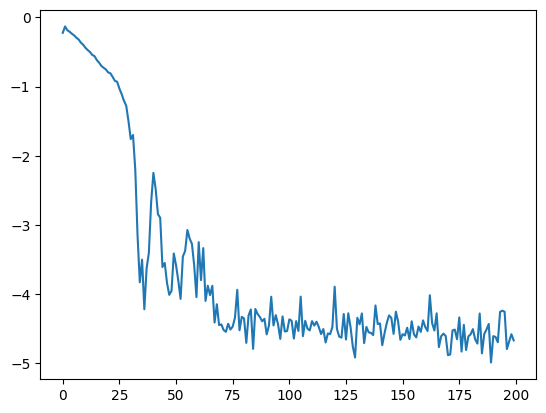

In [120]:
plt.plot(np.log10(syn_model.loss_list))

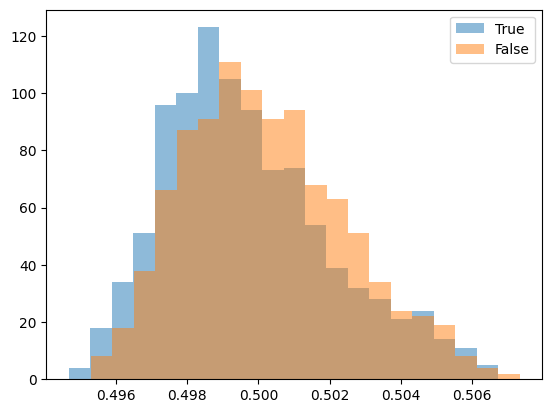

In [121]:
plt.hist(tabpfn_output_proba[y_test==1][:, 0], bins=20, alpha=0.5, label="True")
plt.hist(tabpfn_output_proba[y_test==0][:, 0], bins=20, alpha=0.5, label="False")
plt.legend()

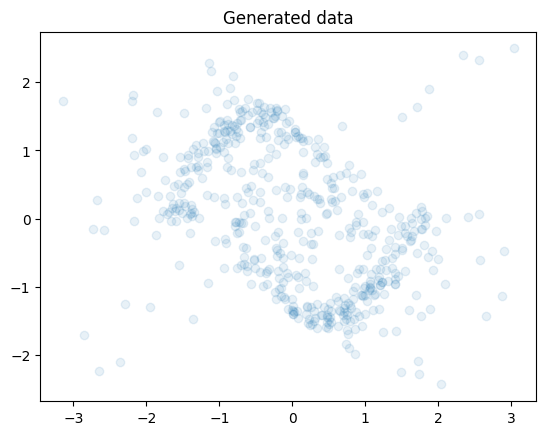

In [122]:
#plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_false_train[:, 0], X_false_train[:, 1], alpha=0.1)
plt.title("Generated data")
plt.show()

In [ ]:
X.shape

(1000, 2)